In [2]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import pathlib
from scipy import interpolate as interp
import pythtb as pytb
import scipy.linalg as la
import astropy as aspy

import sim_tb as stb
import bz_utilities as bzu
import toy_models as toy
import plot_utils as pltu
import linear_response as lr
import analytical_models as amod

In [3]:
alpha, B = 1.69, 0.07
kmax = 0.1*2
lamb = 0.0
th, phi = np.pi/2, 0
path = amod.create_path_rashba_model("", alpha, B=B, th=th, phi=phi, lamb=lamb)
Sim_rash = amod.Rashba_model(path, alpha, B=B, th=th, phi=phi, lamb=lamb)

#Sim_rash.create_bands_grid(kmax=kmax, nk=200)




E min = -222.0 meV
Es = -82.0 meV
Ed = 8.0 meV
Regime: 4.352152380952379


<IPython.core.display.Javascript object>


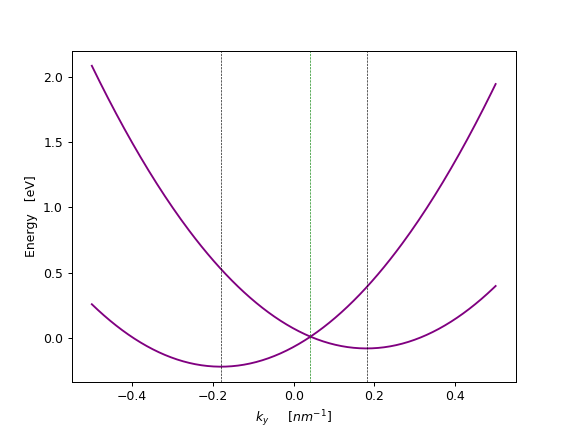

In [4]:
def print_mssg(alpha, B):
    factor = 3/0.32
    e_min= - alpha**2  /factor / 2 - B
    e_s = - alpha**2  / factor / 2 + B
    e_d = factor / 2 * (B/alpha)**2
    print("E min = {} meV".format(np.round(e_min*1e3)))
    print("Es = {} meV".format(np.round(e_s*1e3)))
    print("Ed = {} meV".format(np.round(e_d*1e3)))

print_mssg(alpha, B)
critiq = alpha**2/B / (3/0.32)
print("Regime: {}".format(critiq))
#np.min(Sim_rash.bands_grid[1,:,:])*1e3
fig, ax = plt.subplots()

Sim_rash.plot_bands_1d(ax, nk=200, kmax=0.5)
kd = B/alpha
ks = alpha / 3*0.32
ax.axvline(x=ks, ls="--", color="black", lw=0.5)
ax.axvline(x=-ks,  ls="--", color="black", lw=0.5)
ax.axvline(x=kd,  ls="--", color="green", lw=0.5)

<IPython.core.display.Javascript object>


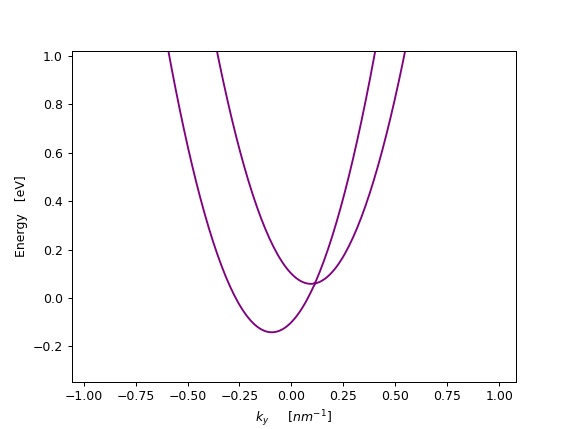

<IPython.core.display.Javascript object>


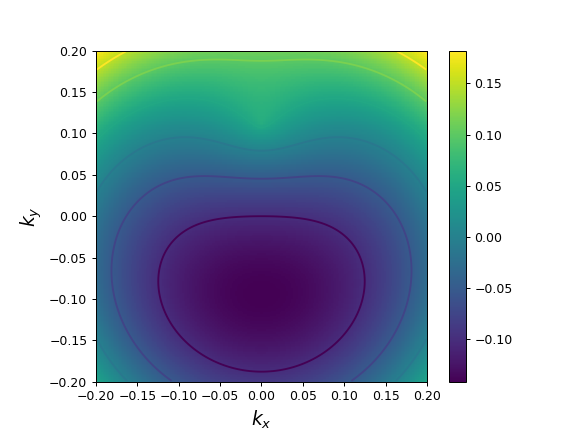

<IPython.core.display.Javascript object>


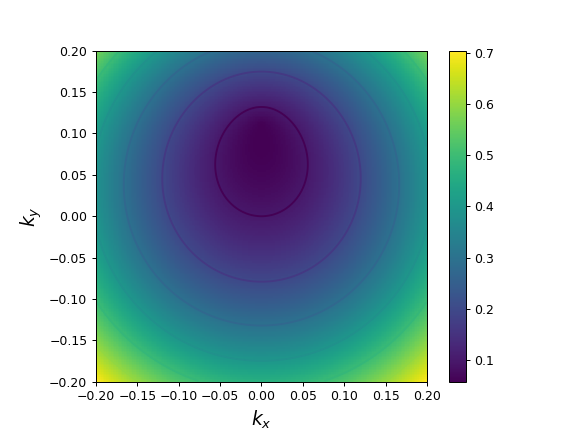

In [36]:
fig, ax = plt.subplots()
Sim_rash.plot_bands_2d(fig, ax, 0, kmax=kmax, cmap="viridis")

fig2, ax2 = plt.subplots()
Sim_rash.plot_bands_2d(fig2, ax2, 1, kmax=kmax, cmap="viridis")


plt.show()

In [3]:
components = (2,0,1)
Gamma = 12.7e-3 # 12.7 meV
Ef = 0.0
kmax = 1
kx = np.linspace(-kmax, kmax, 100)
s_cond = np.zeros_like(kx)
s_cond2 = np.zeros_like(kx)
for i in range(100):
    s_cond[i] = Sim_rash.spin_conductivity_k(kx[i], 0, Ef, *components, Gamma)
    s_cond2[i] = Sim_rash.spin_conductivity_k(0, kx[i], Ef, *components, Gamma)
    
fig, ax = plt.subplots()
ax.plot(kx, s_cond)
ax.plot(kx, s_cond2)

NameError: name 'Sim_rash' is not defined

In [42]:
Ef = 0
Gamma = 12.7e-3
res = Sim_rash.spin_conductivity(Ef, 1,0,1, Gamma, kmax=1)
res

/home/orion178/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:881: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  **opt)


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


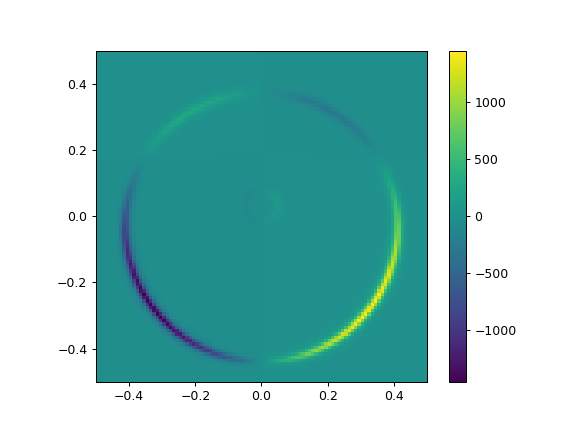

(100, 100)


In [5]:
Ef = 100e-3
Gamma = 12.7e-3 * 3
kmax = 0.5
nk = 100
k = np.linspace(-kmax, kmax, nk)
kx, ky = np.meshgrid(k,k)
s_cond = np.zeros_like(kx)
for x in range(nk):
    for y in range(nk):
        s_cond[x,y] = Sim_rash.spin_conductivity_k(kx[x,y], ky[x,y], Ef, 0,0,1, Gamma)
        
fig, ax = plt.subplots()
print(np.shape(s_cond))
extent = [-kmax, kmax, -kmax, kmax]
img = ax.imshow(s_cond, origin="lower", cmap="viridis", extent = extent)
plt.colorbar(img)



<IPython.core.display.Javascript object>


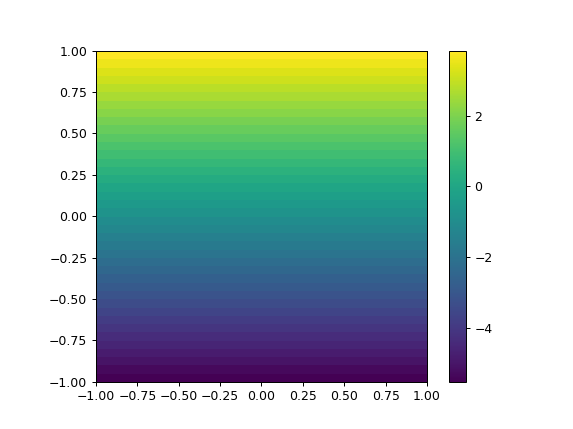

In [20]:
kx, ky = 0.0, 0.0
i, n = 0, 0

kmax = 1
nk = 40
k = np.linspace(-kmax, kmax, nk)
kx, ky = np.meshgrid(k,k)
vorticity = np.zeros_like(kx)
s_current = np.zeros_like(kx)
for x in range(nk):
    for y in range(nk):
        #vorticity[x,y] = Sim_rash.vorticity(kx[x,y], ky[x,y], i, n)
        s_current[x,y] = Sim_rash.spin_current(kx[x,y], ky[x,y], n, i, 1)
        
fig, ax = plt.subplots()
extent = [-kmax, kmax, -kmax, kmax]
img = ax.imshow(s_current, origin="lower", cmap="viridis", extent = extent)
plt.colorbar(img)


In [13]:
p

0.5386383223211723

In [9]:
(0.3)**2 / B

0.8999999999999999

In [10]:
(3/0.32)

9.375

In [15]:
eivals, eivecs = Sim_rash.solve_one(1,0, eig_vectors=True, fix_gauge=True)

In [17]:
eivecs[:, 0]

array([ 0.70710678+8.65956056e-17j, -0.02926335-7.06500995e-01j])

In [32]:
def H_ac(k):
    a1 = np.array([1, 0])
    a2 = np.array([1/2, np.sqrt(3)/2])
    fk = 1 + np.exp(1j * k @ a2)
    t_so = -0.1j * (np.sqrt(3) + 1j) *fk
    return t_so



In [35]:
k = np.array([0.1, 0.1])
H_ac(k)

(0.22265517552116507-0.33117883781125484j)

In [ ]:
1.47 +0.85j